## air data - single Instance Case


In [1]:
import pandas as pd

X_file_path = "/workspaces/Masterthesis-DRF/Data/Air and Wage /Air_X_export.csv"
Y_file_path = "/workspaces/Masterthesis-DRF/Data/Air and Wage /Air_Y_export.csv"

X_df = pd.read_csv(X_file_path)
Y_df = pd.read_csv(Y_file_path)


Feature target correlation to find a basis for creating IDs


Longitude                                   64
Latitude                                    64
Elevation                                   62
Weekday                                      7
Month                                       12
Time                                      1734
Land.Use_AGRICULTURAL                        2
Land.Use_COMMERCIAL                          2
Land.Use_FOREST                              2
Land.Use_INDUSTRIAL                          2
Land.Use_MILITARY RESERVATION                2
Land.Use_RESIDENTIAL                         2
Location.Setting_RURAL                       2
Location.Setting_SUBURBAN                    2
Location.Setting_URBAN AND CENTER CITY       2
dtype: int64


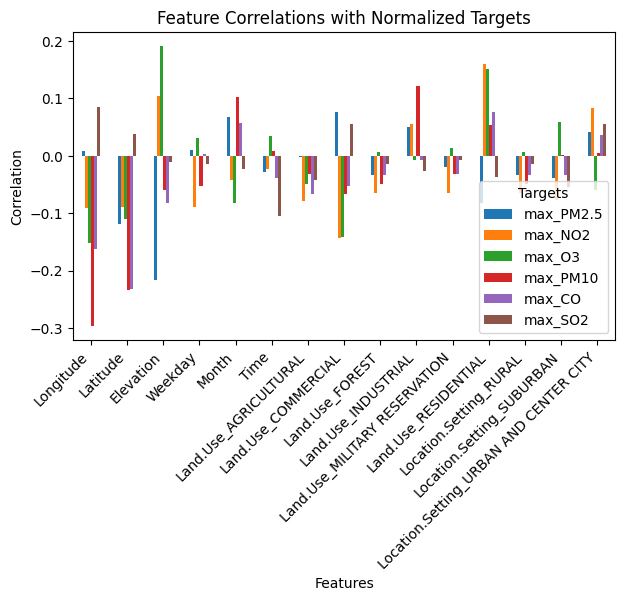

In [2]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

unique_values_per_column = X_df.nunique()
print(unique_values_per_column)


scaler = MinMaxScaler()
Y_normalized = pd.DataFrame(scaler.fit_transform(Y_df), columns=Y_df.columns)

correlation_table = pd.DataFrame()

for target in Y_normalized.columns:
    correlation_table[target] = X_df.corrwith(Y_normalized[target])

correlation_table['Features'] = X_df.columns
correlation_table.set_index('Features', inplace=True)

correlation_table.plot(kind='bar', figsize=(7, 4))
plt.title('Feature Correlations with Normalized Targets')
plt.ylabel('Correlation')
plt.xlabel('Features')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Targets')

plt.show()


Time Series Decomposition

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

data_combined = pd.concat([X_df, Y_df], axis=1)
df = data_combined

## Melt the DataFrame
df_melted = df.melt(id_vars=['Month', 'Weekday', 'Time'],
                    value_vars=['max_PM2.5', 'max_NO2', 'max_O3', 'max_PM10', 'max_CO', 'max_SO2'],
                    var_name='Pollutant',
                    value_name='Max Value')

# Set up the plot size
fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=False)

# Plot 1: Max Pollutants by Month
sns.lineplot(data=df_melted, x='Month', y='Max Value', hue='Pollutant', ax=axes[0])
axes[0].legend_.remove()  # Remove the legend from this plot
axes[0].set_title('Max Pollutant Levels by Month')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Max Value')

# Plot 2: Max Pollutants by Weekday
sns.lineplot(data=df_melted, x='Weekday', y='Max Value', hue='Pollutant', ax=axes[1])
axes[1].legend_.remove()  # Remove the legend from this plot
axes[1].set_title('Max Pollutant Levels by Weekday')
axes[1].set_xlabel('Weekday')
axes[1].set_ylabel('Max Value')

# Plot 3: Max Pollutants by Time
sns.lineplot(data=df_melted, x='Time', y='Max Value', hue='Pollutant', ax=axes[2])
axes[2].legend_.remove()  # Remove the legend from this plot
axes[2].set_title('Max Pollutant Levels by Time')
axes[2].set_xlabel('Time')
axes[2].set_ylabel('Max Value')

# Add a shared legend on the right side
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title='Pollutant', loc='center left', bbox_to_anchor=(1.02, 0.5), borderaxespad=0, ncol=1)

# Adjust layout for readability
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust right space for the legend
plt.show()

observations per location

In [ ]:
import pandas as pd

# Assuming X_df is your DataFrame
# Group by Longitude and Latitude, and count the occurrences of each location
location_counts = X_df.groupby(['Longitude', 'Latitude']).size().reset_index(name='counts')
location_counts_sorted = location_counts.sort_values(by='counts', ascending=False)

# Output the sorted counts for each location
print(location_counts_sorted)



     Longitude   Latitude  counts
35  -91.179219  30.461981    1619
9  -119.773210  36.785380    1537
53  -77.013178  38.921847    1520
8  -119.807717  39.525083    1516
27  -96.700769  43.547920    1507
..         ...        ...     ...
59  -73.297257  41.821342     131
4  -122.026154  37.936013     125
62  -72.631667  41.784722      85
49  -79.902222  40.146667      54
39  -87.799227  42.139996      42

[64 rows x 3 columns]


Cluster the locations in bigger ones

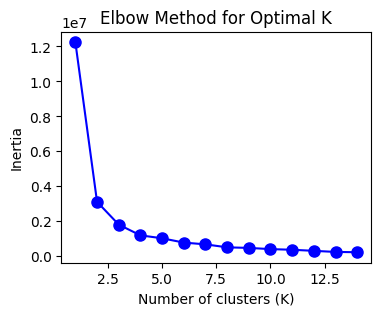

In [4]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")
# Step 1: Extract longitude and latitude as features for clustering
coords = X_df[['Longitude', 'Latitude']]

# Step 2: Determine inertia for different numbers of clusters
inertia = []
K = range(1, 15)  # You can try more values depending on your dataset size

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(coords)
    inertia.append(kmeans.inertia_)

# Step 3: Plot the Elbow Curve
plt.figure(figsize=(4, 3))
plt.plot(K, inertia, 'bo-', markersize=8)
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()


create the locations based on clusters

In [5]:
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np

# Step 1: Extract longitude and latitude as features for clustering
coords = X_df[['Longitude', 'Latitude']]

# Step 2: Apply KMeans clustering with a desired number of clusters (e.g., 10 clusters)
kmeans = KMeans(n_clusters=6, random_state=42)  # You can change the number of clusters
X_df['location_cluster'] = kmeans.fit_predict(coords)

# Step 3: Merge the location clusters back into the combined DataFrame
data_combined = pd.concat([X_df, Y_df], axis=1)
data_combined['location'] = data_combined['location_cluster'].apply(lambda x: f'Location_{x+1}')

# Step 4: Sort the DataFrame by 'location', 'Month', and 'Weekday' to ensure proper ordering
data_combined = data_combined.sort_values(by=['location', 'Month', 'Weekday', 'Time']).reset_index(drop=True)

# Step 5: Create a unique dayIndex for each location
data_combined['dayIndex'] = data_combined.groupby('location').cumcount() + 1

# Step 6: Count the number of dayIndex values per location
index_counts_per_location = data_combined.groupby('location')['dayIndex'].max().reset_index(name='num_indices')

# Step 7: Display the updated DataFrame with new location labels and dayIndex column
display(index_counts_per_location)
display(data_combined.head(10))


,location,num_indices
0,Location_1,5819
1,Location_2,11417
2,Location_3,4024
3,Location_4,11019
4,Location_5,4225
5,Location_6,6547


,Longitude,Latitude,Elevation,Weekday,Month,Time,Land.Use_AGRICULTURAL,Land.Use_COMMERCIAL,Land.Use_FOREST,Land.Use_INDUSTRIAL,...,Location.Setting_URBAN AND CENTER CITY,location_cluster,max_PM2.5,max_NO2,max_O3,max_PM10,max_CO,max_SO2,location,dayIndex
0,-106.585200,35.134300,1591.0,1,1,4,0,0,0,0,...,1,0,24.300000,41.6,0.022,39.0,0.9,4.1,Location_1,1
1,-104.778334,41.182227,1842.0,1,1,4,0,0,0,0,...,0,0,6.500000,31.9,0.039,8.0,0.1,0.4,Location_1,2
2,-112.095767,33.503833,343.0,1,1,11,0,0,0,0,...,1,0,11.100000,36.0,0.023,18.0,0.9,2.6,Location_1,3
3,-106.585200,35.134300,1591.0,1,1,11,0,0,0,0,...,1,0,9.000000,28.1,0.018,18.0,0.6,1.4,Location_1,4
4,-111.872222,40.736389,1304.0,1,1,11,0,0,0,0,...,0,0,18.900000,40.0,0.004,23.0,1.1,0.4,Location_1,5
5,-104.778334,41.182227,1842.0,1,1,11,0,0,0,0,...,0,0,8.433333,7.1,0.034,9.0,0.1,0.3,Location_1,6
6,-104.987625,39.751184,1593.0,1,1,11,0,1,0,0,...,1,0,14.000000,37.9,0.005,23.0,0.5,1.0,Location_1,7
7,-105.005180,39.779490,1602.0,1,1,11,0,0,0,0,...,1,0,14.400000,31.1,0.011,19.0,0.3,0.8,Location_1,8
8,-112.095767,33.503833,343.0,1,1,18,0,0,0,0,...,1,0,13.000000,44.0,0.030,33.0,1.4,4.0,Location_1,9
9,-106.585200,35.134300,1591.0,1,1,18,0,0,0,0,...,1,0,12.900000,38.4,0.026,21.0,0.7,3.5,Location_1,10


create Plot

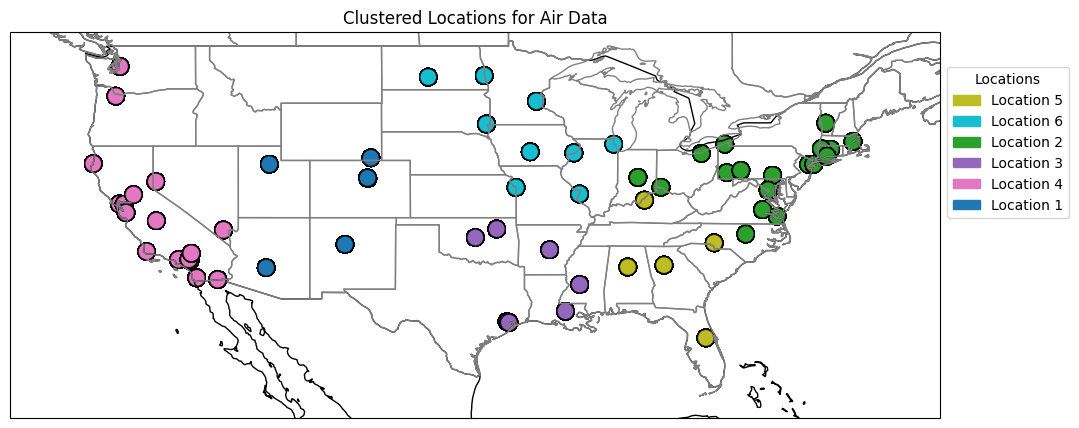

In [9]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches

import matplotlib.patches as mpatches


fig, ax = plt.subplots(figsize=(12,8), subplot_kw={'projection': ccrs.PlateCarree()})

ax.add_feature(cfeature.COASTLINE)    # Coastlines
ax.add_feature(cfeature.BORDERS, edgecolor='black')  # Country borders
ax.add_feature(cfeature.STATES, edgecolor='gray')    # U.S. state boundaries

scatter = ax.scatter(X_df['Longitude'], X_df['Latitude'],
                     c=X_df['location_cluster'], cmap='tab10',
                     s=150, alpha=0.8, edgecolor='k')

unique_clusters = X_df['location_cluster'].unique()


legend_patches = [mpatches.Patch(color=plt.cm.tab10(cluster / max(unique_clusters)),
                                 label=f'Location {cluster+1}') for cluster in unique_clusters]


plt.legend(handles=legend_patches, title="Locations", loc='lower left', bbox_to_anchor=(1, 0.5))

ax.set_extent([-130, -65, 23, 50], crs=ccrs.PlateCarree())

plt.title("Clustered Locations for Air Data")
plt.show()


melt IDs together

In [ ]:
import pandas as pd


grouped_data = data_combined

target_columns = ['max_PM2.5', 'max_NO2', 'max_O3', 'max_PM10', 'max_CO', 'max_SO2']

id_vars = ['location', 'Longitude', 'Latitude', 'Elevation', 'Weekday', 'Month', "Time",'dayIndex',
           'Land.Use_AGRICULTURAL', 'Land.Use_COMMERCIAL', 'Land.Use_FOREST',
           'Land.Use_INDUSTRIAL', 'Location.Setting_SUBURBAN', 'Location.Setting_URBAN AND CENTER CITY']

# Schmelze die Tabelle: Zielvariablen werden in eine Spalte 'demand' umgewandelt,
# während die restlichen Spalten beibehalten werden.
melted_data = pd.melt(grouped_data,
                      id_vars=id_vars,  # Behalte diese Spalten bei
                      value_vars=target_columns,  # Zielspalten, die in die Spalte 'demand' geschmolzen werden
                      var_name='target',  # Spalte, die die Zielspaltennamen enthält
                      value_name='demand')  # Spalte, die die Werte der Zielspalten enthält

# Erstelle die 'id'-Spalte als Kombination aus 'location' und 'target'
melted_data['id'] = melted_data['location'] + '_' + melted_data['target']


add train/test label for each ID seperately

In [11]:
from sklearn.model_selection import train_test_split
# Liste für die getrennten Datensätze
train_frames = []
test_frames = []

for id_value, group in melted_data.groupby('id'):
    # Prüfe, ob die Gruppe genügend Zeilen für einen Split enthält
    if len(group) > 1:  # Sicherstellen, dass mindestens 2 Zeilen vorhanden sind
        # Splitte die Gruppe in 80% Training und 20% Test, ohne Shuffle
        train, test = train_test_split(group, test_size=0.2, shuffle=False)

        # Speichere die getrennten Frames
        train_frames.append(train)
        test_frames.append(test)
    else:
        # Wenn nur eine Zeile vorhanden ist, alles in den Trainingsdatensatz übernehmen
        train_frames.append(group)

final_data = pd.concat(train_frames + test_frames).reset_index(drop=True)

# Füge die Spalte 'label' hinzu, um anzuzeigen, ob die Zeile 'train' oder 'test' ist
final_data['label'] = ['train'] * len(pd.concat(train_frames)) + ['test'] * len(pd.concat(test_frames))

display(final_data)


,location,Longitude,Latitude,Elevation,Weekday,Month,Time,dayIndex,Land.Use_AGRICULTURAL,Land.Use_COMMERCIAL,Land.Use_FOREST,Land.Use_INDUSTRIAL,Location.Setting_SUBURBAN,Location.Setting_URBAN AND CENTER CITY,target,demand,id,label
0,Location_1,-106.585200,35.134300,1591.0,1,1,4,1,0,0,0,0,0,1,max_CO,0.9,Location_1_max_CO,train
1,Location_1,-104.778334,41.182227,1842.0,1,1,4,2,0,0,0,0,1,0,max_CO,0.1,Location_1_max_CO,train
2,Location_1,-112.095767,33.503833,343.0,1,1,11,3,0,0,0,0,0,1,max_CO,0.9,Location_1_max_CO,train
3,Location_1,-106.585200,35.134300,1591.0,1,1,11,4,0,0,0,0,0,1,max_CO,0.6,Location_1_max_CO,train
4,Location_1,-111.872222,40.736389,1304.0,1,1,11,5,0,0,0,0,1,0,max_CO,1.1,Location_1_max_CO,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258301,Location_6,-94.635605,39.117219,273.0,7,12,1459,6543,0,0,0,0,0,1,max_SO2,0.9,Location_6_max_SO2,test
258302,Location_6,-93.207615,45.137680,277.0,7,12,1459,6544,0,1,0,0,1,0,max_SO2,0.3,Location_6_max_SO2,test
258303,Location_6,-90.198348,38.656429,155.0,7,12,1459,6545,0,0,0,0,0,1,max_SO2,1.7,Location_6_max_SO2,test
258304,Location_6,-100.768210,46.825425,566.0,7,12,1459,6546,0,0,0,0,1,0,max_SO2,0.6,Location_6_max_SO2,test


safe data

In [ ]:
import pandas as pd

processed_air_data = final_data.copy()

processed_air_data.to_csv('processed_air_data.csv', index=False)


## load air data - Full Dataset case

In [2]:
import pandas as pd

X_file_path = "/workspaces/Masterthesis-DRF/Data/Air and Wage /Air_X_export.csv"
Y_file_path = "/workspaces/Masterthesis-DRF/Data/Air and Wage /Air_Y_export.csv"

X_df = pd.read_csv(X_file_path)
Y_df = pd.read_csv(Y_file_path)


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import pandas as pd

pd.set_option('display.max_columns', None)

# Combine X_df and Y_df into a single DataFrame
data = pd.concat([X_df, Y_df], axis=1)
df = pd.DataFrame(data)

# Apply K-Means clustering to create location clusters based on (Longitude, Latitude)
num_clusters = 6  # Set the number of clusters as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['location'] = kmeans.fit_predict(df[['Longitude', 'Latitude']])
df['location'] = df['location'].apply(lambda x: f"Location {x+1}")  # Format as "Location X"

# One-hot encode the location column
df = pd.get_dummies(df, columns=['location'], dtype=int)
df.columns = [col.replace('location_', '') if col.startswith('location_') else col for col in df.columns]  # Remove redundant prefix

# Sort by time-related columns and then create dayIndex within each location
df = df.sort_values(by=['Month', 'Weekday', 'Time'])
df['dayIndex'] = df.groupby([col for col in df.columns if col.startswith('Location ')])['Time'].cumcount() + 1

# Split data into train and test sets without shuffling (time series structure)
train_df, test_df = train_test_split(df, test_size=0.2, shuffle=False)

# Label train and test sets for easy tracking
train_df['label'] = 'train'
test_df['label'] = 'test'

# Combine the labeled train and test data for consistent processing
df_labeled = pd.concat([train_df, test_df], ignore_index=True)

# Identify columns that start with 'max_'
max_columns = [col for col in df.columns if col.startswith('max_')]

# Initialize and apply MinMaxScaler on the target columns
scaler = MinMaxScaler()
df_labeled.loc[df_labeled['label'] == 'train', max_columns] = scaler.fit_transform(df_labeled.loc[df_labeled['label'] == 'train', max_columns])
df_labeled.loc[df_labeled['label'] == 'test', max_columns] = scaler.transform(df_labeled.loc[df_labeled['label'] == 'test', max_columns])

# Reshape data for pollutants by melting, keeping 'label' as an identifier
df_melted = pd.melt(df_labeled,
                    id_vars=[col for col in df.columns if col not in max_columns] + ['label'],
                    value_vars=max_columns,
                    var_name='pollutant',  # New column for pollutant types
                    value_name='demand')   # Column with pollutant values

# One-hot encode the pollutant column
df_encoded = pd.get_dummies(df_melted, columns=['pollutant'], dtype=int)

# Define pollutant columns
pollutant_columns = ['pollutant_max_CO', 'pollutant_max_NO2', 'pollutant_max_O3',
                     'pollutant_max_PM10', 'pollutant_max_PM2.5', 'pollutant_max_SO2']

# Function to generate unique id based only on pollutant type and location
def generate_id(row):
    pollutant = next((col for col in pollutant_columns if row[col] > 0), None)
    location = next((col for col in location_columns if row[col] == 1), None)
    return f"{pollutant}_{location}" if pollutant and location else None

# Apply the function to generate the id column
location_columns = [col for col in df_encoded.columns if col.startswith('Location ')]
df_encoded['id'] = df_encoded.apply(generate_id, axis=1)

# Reorder columns to make 'demand' and 'id' the first columns, keeping 'label' for train/test identification
cols = ['demand', 'id', 'label', "dayIndex"] + [col for col in df_encoded.columns if col not in ['demand', 'id', 'label', "dayIndex"]]
df = df_encoded[cols]

# Sort DataFrame by 'dayIndex' and 'id'
df = df.sort_values(by=["dayIndex", "id"])

# Display final DataFrame structure
display(df)


/workspaces/Masterthesis-DRF/.venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,demand,id,label,dayIndex,Longitude,Latitude,Elevation,Weekday,Month,Time,Land.Use_AGRICULTURAL,Land.Use_COMMERCIAL,Land.Use_FOREST,Land.Use_INDUSTRIAL,Land.Use_MILITARY RESERVATION,Land.Use_RESIDENTIAL,Location.Setting_RURAL,Location.Setting_SUBURBAN,Location.Setting_URBAN AND CENTER CITY,Location 1,Location 2,Location 3,Location 4,Location 5,Location 6,pollutant_max_CO,pollutant_max_NO2,pollutant_max_O3,pollutant_max_PM10,pollutant_max_PM2.5,pollutant_max_SO2
172204,0.218750,pollutant_max_CO_Location 1,train,1,-84.290500,33.687800,239.0,1,1,4,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0
172207,0.593750,pollutant_max_CO_Location 2,train,1,-119.807717,39.525083,1380.0,1,1,4,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0
172208,0.406250,pollutant_max_CO_Location 3,train,1,-106.585200,35.134300,1591.0,1,1,4,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0
172206,0.250000,pollutant_max_CO_Location 4,train,1,-93.207615,45.137680,277.0,1,1,4,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0
172211,0.156250,pollutant_max_CO_Location 5,train,1,-76.699444,39.965278,131.0,1,1,4,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86098,0.215837,pollutant_max_NO2_Location 2,test,11019,-120.457500,34.637820,34.0,7,12,1459,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0
129149,0.193548,pollutant_max_O3_Location 2,test,11019,-120.457500,34.637820,34.0,7,12,1459,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0
172200,0.089109,pollutant_max_PM10_Location 2,test,11019,-120.457500,34.637820,34.0,7,12,1459,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
43047,0.142218,pollutant_max_PM2.5_Location 2,test,11019,-120.457500,34.637820,34.0,7,12,1459,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0


safe data

In [ ]:

full_air_data = df.copy()

full_air_data.to_csv('air_data_FULLDATASET.csv', index=False)